<a href="https://colab.research.google.com/github/ssktotoro/neuro/blob/tutorial_branch/Mindboggle_Prediction_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mindboggle DKT Cortical Prediction and Visualization

In this notebook we demonstrate how to perform inference with pretrained MeshNet and UNet models.  **MeshNet** can be to **1.5x faster** and **>30x smaller** while maintaining comparable performance to UNet.

## Model Performance

| Model      | Macro DICE |  Inference Speed | Model Size | Classes
| -----------| ----------- |----------- |----------- |----------- |
| MeshNet Large  | .6742 | 19 subvolumes/sec | 9mb | 31
| UNet  | .6771  | 13 subvolumes/sec |  288 mb | 31

---

Authors: [Kevin Wang](https://github.com/ssktotoro/), [Alex Fedorov](https://github.com/Entodi/), [Sergey Kolesnikov](https://github.com/Scitator)

[![Catalyst logo](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)](https://github.com/catalyst-team/catalyst)

### Colab setup

First of all, do not forget to change the runtime type to GPU. <br/>
To do so click `Runtime` -> `Change runtime type` -> Select `\"Python 3\"` and `\"GPU\"` -> click `Save`. <br/>
After that you can click `Runtime` -> `Run all` and watch the tutorial.

## Setup Environment

In [ ]:
%%bash 
git clone https://github.com/ssktotoro/neuro.git -b tutorial_branch
pip install -r neuro/requirements/requirements.txt

In [2]:
cd neuro/

/content/neuro


In [3]:
from infer import Predictor
from training.model import MeshNet, UNet
import torch
import nibabel as nib
from catalyst.metrics.functional._segmentation import dice
import matplotlib.pyplot as plt

%matplotlib inline

##Dataset

We'll be using the Mindboggle 101 dataset for a multiclass 3d segmentation task.
The dataset can be downloaded off osf with the following command from osfclient after you register with osf.

`osf -p 9ahyp clone .`

Otherwise you can download it using a Catalyst utility `download-gdrive` which downloads a version from the Catalyst Google Drive

`usage: download-gdrive {FILE_ID} {FILENAME}`

In [ ]:
%%bash
mkdir Mindboggle_data 
mkdir -p data/Mindboggle_101/
osf -p 9ahyp clone Mindboggle_data/
cp -r Mindboggle_data/osfstorage/Mindboggle101_volumes/ data/Mindboggle_101/
find data/Mindboggle_101 -name '*.tar.gz'| xargs -i tar zxvf {} -C data/Mindboggle_101
find data/Mindboggle_101 -name '*.tar.gz'| xargs -i rm {}

Run the prepare data script that limits the labels to the DKT cortical labels (31 labels).  We can use of course use more labels.

`usage: python ../neuro/scripts/prepare_data.py ../data/Mindboggle_101 {N_labels)`

In [ ]:
%%bash 

python neuro/scripts/prepare_data.py data/Mindboggle_101/ 31

## Download Models

In [ ]:
%%bash 

download-gdrive 11i-gPKoLzEUVqVJ0UNCjG30HFuMXODkG meshnet_mindboggle_large_train.30_full.pth
download-gdrive 1gVjj1gYoPLk8BjZHXsznS6fbbWJaN3Gb unet_mindboggle_train.30_full.pth

### Prepare Models for inference

In [7]:
volume_shape = [256, 256, 256]
subvolume_shape = [38, 38, 38]
n_subvolumes = 512
n_classes = 31
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

meshnet_large_model = MeshNet(n_channels=1, n_classes=n_classes, large=True)
meshnet_large_model.load_state_dict(torch.load('meshnet_mindboggle_large_train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_large_model.to(device)
meshnet_large_predictor = Predictor(meshnet_large_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

unet_model = UNet(n_channels=1, n_classes=n_classes)
unet_model.load_state_dict(torch.load('unet_mindboggle_train.30_full.pth', map_location=device)['model_state_dict'])
unet_model.to(device)
unet_predictor = Predictor(unet_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

##Segment Mindboggle TestBrain with Timing and DICE Metric

In [8]:
%time meshnet_predicted_segmentation = meshnet_large_predictor.predict('data/Mindboggle_101/NKI-TRT-20_volumes/NKI-TRT-20-5/t1weighted.nii.gz')

CPU times: user 23.7 s, sys: 433 ms, total: 24.1 s
Wall time: 24.3 s


In [9]:
%time unet_predicted_segmentation = unet_predictor.predict('data/Mindboggle_101/NKI-TRT-20_volumes/NKI-TRT-20-5/t1weighted.nii.gz')

CPU times: user 34.4 s, sys: 27.3 ms, total: 34.4 s
Wall time: 34.5 s


In [10]:
img = nib.load('data/Mindboggle_101/NKI-TRT-20_volumes/NKI-TRT-20-5/t1weighted.nii.gz')
img = img.get_fdata()

labels = nib.load('data/Mindboggle_101/NKI-TRT-20_volumes/NKI-TRT-20-5/labels.DKT31.manual+aseg_labels.nii.gz')
labels = labels.get_fdata()

##Visualize Predictions

In [15]:
def show_slices(slices, raw=True):
    if raw:
        cmap = 'jet'
    else:
        cmap = 'nipy_spectral'
    fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap='nipy_spectral')

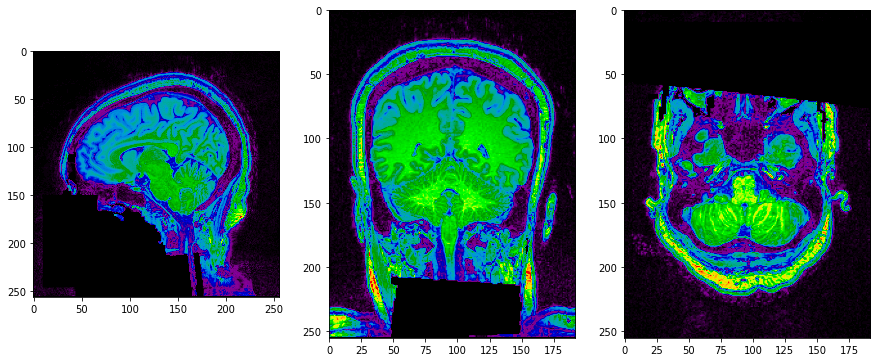

In [34]:
show_slices(
    [img[100, :,:].T[::-1][:, ::-1], 
     img[:, 100,:].T[::-1], 
     img[:, :, 100].T[::-1]
     ])

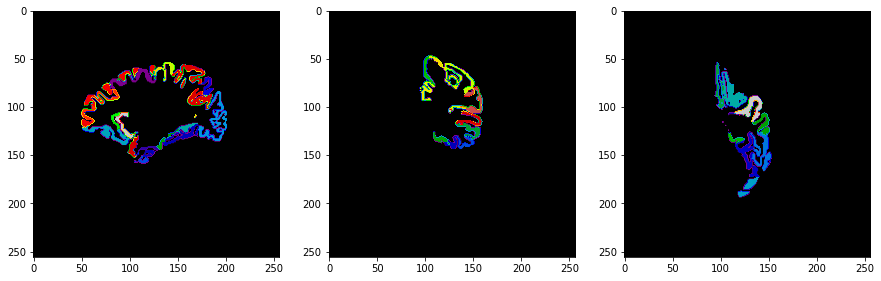

In [38]:
show_slices(
    [labels[120, :,:].T[::-1][:, ::-1], 
     labels[:, 120,:].T[::-1],
     labels[:, :, 120].T[::-1]
     ], raw=False)

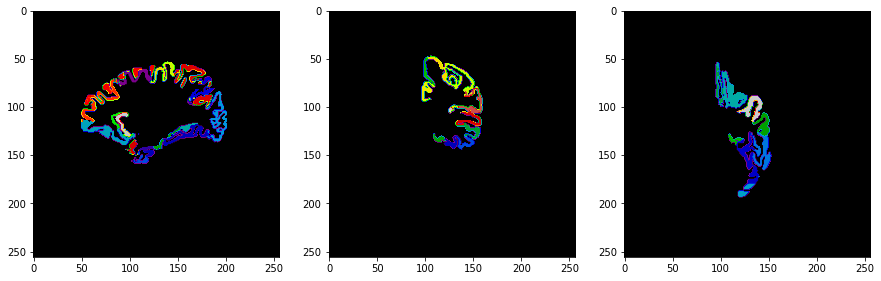

In [44]:
show_slices(
    [meshnet_predicted_segmentation[120, :,:].cpu().numpy().T[::-1][:, ::-1], 
     meshnet_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     meshnet_predicted_segmentation[:, :,120].cpu().numpy().T[::-1]
     ], raw=False)

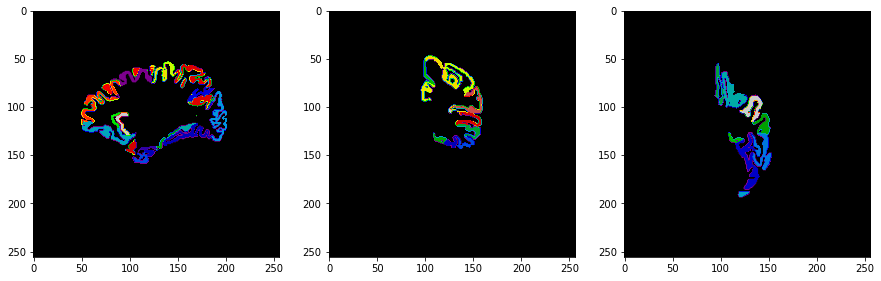

In [46]:
show_slices(
    [unet_predicted_segmentation[120, :,:].cpu().numpy().T[::-1][:, ::-1], 
     unet_predicted_segmentation[:, 120,:].cpu().numpy().T[::-1], 
     unet_predicted_segmentation[:, :,120].cpu().numpy().T[::-1]
     ], raw=False)